In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as obj_lib
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

from scikits.sparse.cholmod import cholesky

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
use_simulated_data = True
if use_simulated_data:
    num_obs_per_group = 2
    analysis_name = 'simulated_data_for_refit_{}'.format(num_obs_per_group)
    pickle_output_filename = os.path.join(data_dir, '%s_python_refit_jackknife_results.pkl' % analysis_name)
else:
    #analysis_name = 'simulated_data_small'
    analysis_name = 'criteo_subsampled'
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')

vb_data = pickle.load(pkl_file)
model = logit_glmm.load_model_from_pickle(vb_data)
timer = obj_lib.Timer()
kl_hess = obj_lib.unpack_csr_matrix(vb_data['kl_hess_packed'])
moment_jac = vb_data['moment_jac']
moment_wrapper = logit_glmm.MomentWrapper(model.glmm_par)
opt_glmm_free_par = vb_data['glmm_par_free']

In [3]:
def optimize_with_weights(
    model, weights, init_par, preconditioner, gtol=1e-8, print_every=1, verbose=True):

    model.use_weights = True
    model.weights = copy.deepcopy(weights)
    preconditioned_init_par = sp.sparse.linalg.spsolve(preconditioner, init_par)
    return model.tr_optimize_cond(
        preconditioned_init_par,
        preconditioner=preconditioner,
        num_gh_points=model.num_gh_points,
        gtol=gtol,
        print_every=print_every,
        verbose=verbose)   


In [4]:
# Pre-condition with the KL Hessian from the original analysis.
preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
preconditioner = sp.sparse.csr_matrix(preconditioner)

In [5]:
base_weights = np.full(model.x_mat.shape[0], 1.0)
print(np.sum(base_weights))
base_opt = optimize_with_weights(
    model=model,
    preconditioner=preconditioner,
    weights=base_weights,
    init_par=opt_glmm_free_par,
    gtol=1e-8)
base_free_par = model.objective.uncondition_x(base_opt.x)

400.0
Iter  0  value:  180.641051534
Iter  1  value:  167.18334515
Iter  2  value:  143.195482526
Iter  3  value:  106.929697777
Iter  4  value:  85.9765019632
Iter  5  value:  84.1544213421
Iter  6  value:  83.6013260856
Iter  7  value:  83.5561720339
Iter  8  value:  83.540837384
Iter  9  value:  83.5369829757
Iter  10  value:  83.5369740926
Iter  11  value:  83.5369740924
Iter  12  value:  83.5369740924
         Current function value: 83.536974
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 12
         Hessian evaluations: 0


In [6]:
timer.tic()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
timer.toc('moment_jac_time')
moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

moment_jac_time: 0.1655426025390625 seconds


In [7]:
# Get a sparse Jacobian.
timer.tic()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=200)
timer.toc('weight_jac_time')
print('Jacobian time: ', timer.time_dict['weight_jac_time'])

Group 0 of 199
weight_jac_time: 0.6683769226074219 seconds
Jacobian time:  0.6683769226074219


In [8]:
# Get a sparse Hessian.
timer.tic()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=200)
timer.toc('hess_time')
print('Hessian time: ', timer.time_dict['hess_time'])

Group 0 of 199.
hess_time: 2.8260979652404785 seconds
Hessian time:  2.8260979652404785


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [9]:
# Invert to get parameter sensitivity.
timer.tic()
print('Cholesky...')
kl_hess_chol = cholesky(kl_hess)
print('Solving...')
param_boot_mat = -1 * kl_hess_chol.solve_A(weight_jacobian.T)
print('Done.')
timer.toc('inverse_time')

Cholesky...
Solving...
Done.
inverse_time: 0.007557392120361328 seconds


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  after removing the cwd from sys.path.


In [21]:
def lr_bootstrap(model, param_boot_mat, base_free_par):
    num_obs = model.x_mat.shape[0]
    boot_draw = np.random.multinomial(num_obs, [1. / num_obs] * num_obs, size=1)
    boot_draw = np.asarray(np.squeeze(boot_draw))
    lr_param_diff = param_boot_mat * (boot_draw - 1.0)
    glmm_par_lr_boot = base_free_par + lr_param_diff
    return glmm_par_lr_boot, boot_draw

def bootstrap_and_refit(model, preconditioner, param_boot_mat, base_free_par):
    glmm_par_lr_boot, boot_draw = lr_bootstrap(model, param_boot_mat, base_free_par)
    glmm_par_opt_boot = optimize_with_weights(
        model=model,
        preconditioner=preconditioner,
        init_par=glmm_par_lr_boot,
        weights=boot_draw,
        gtol=1e-8,
        verbose=False)
    boot_free_par = model.objective.uncondition_x(glmm_par_opt_boot.x)
    return boot_free_par, glmm_par_opt_boot, glmm_par_lr_boot, boot_draw

In [20]:
num_boot_samples = 50
lr_boot_free_par_list = []
boot_free_par_list = []
boot_draw_list = []
timer.tic()
for boot in range(num_boot_samples):
    if boot % 5 == 0:
        print('Bootstrap {} of {}'.format(boot + 1, num_boot_samples))
    boot_free_par, glmm_par_opt_boot, glmm_par_lr_boot, boot_draw = \
        bootstrap_and_refit(model, preconditioner, param_boot_mat, base_free_par)
    boot_free_par_list.append(boot_free_par)
    lr_boot_free_par_list.append(glmm_par_lr_boot)
    boot_draw_list.append(boot_draw)
timer.toc('bootstrap_time')

Bootstrap 1 of 50
Bootstrap 6 of 50
Bootstrap 11 of 50
Bootstrap 16 of 50
Bootstrap 21 of 50
Bootstrap 26 of 50
Bootstrap 31 of 50
Bootstrap 36 of 50
Bootstrap 41 of 50
Bootstrap 46 of 50
bootstrap_time: 110.065758228302 seconds


In [23]:
lr_boot_free_par_list_long = []
num_long_boot_samples = 2000
timer.tic()
for boot in range(num_long_boot_samples):
    glmm_par_lr_boot, boot_draw = lr_bootstrap(model, param_boot_mat, base_free_par)
    lr_boot_free_par_list_long.append(glmm_par_lr_boot)
timer.toc('lr_bootstrap_time')


lr_bootstrap_time: 0.41641783714294434 seconds


True param difference: 23.31890385805021
True moment norm difference: 16.87625896068708


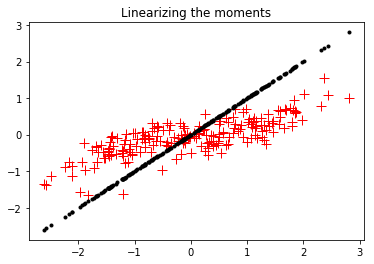

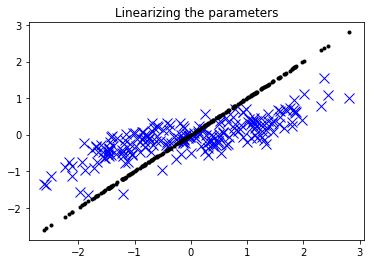

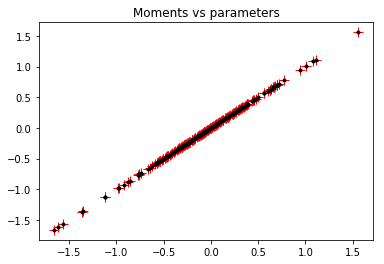

In [18]:
# The actual change in the moment vectors.
boot = 2
boot_free_par = boot_free_par_list[boot]
lr_boot_free_par = lr_boot_free_par_list[boot]

moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)
true_moment_diff = moment_vec_boot - moment_vec
print('True param difference: {}'.format(np.linalg.norm(base_free_par - boot_free_par)))
print('True moment norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

# Use the linear approximation for the parameters, not the moments.
moment_pred_from_params = \
    moment_wrapper.get_moment_vector_from_free(lr_boot_free_par)
moment_pred_from_params_diff = moment_pred_from_params - moment_vec

# The difference based on a linear approximation to the moments.
moment_pred_from_moments_diff = moment_jac_sp * (lr_boot_free_par - base_free_par)

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, moment_pred_from_params_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

# It doesn't make a difference whether you linearize the moments or parameters.
plt.figure()
plt.title('Moments vs parameters')
plt.plot(moment_pred_from_params_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(moment_pred_from_params_diff, moment_pred_from_params_diff, 'k.')
#plt.axis([-10, 10, -10, 10])



In [29]:
# Get the moments in a list form.

lr_boot_moment_vec_list = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in lr_boot_free_par_list ]
lr_boot_moment_vec_list_long = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in lr_boot_free_par_list_long ]
boot_moment_vec_list = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in boot_free_par_list ]
    


In [30]:
# Write the result to a pickle file for use in R.

run_name = 'jackknife'

pickle_result_filename = os.path.join(data_dir, '%s_python_vb_jackknife_results.pkl' % analysis_name)
pickle_output = open(pickle_result_filename, 'wb')

pickle_result_dict = {  'boot_free_par_list': boot_free_par_list,
                        'lr_boot_free_par_list': lr_boot_free_par_list,
                        'lr_boot_free_par_list_long': lr_boot_free_par_list_long,
                        'lr_boot_moment_vec_list': lr_boot_moment_vec_list,
                        'lr_boot_moment_vec_list_long': lr_boot_moment_vec_list_long,
                        'boot_moment_vec_list': boot_moment_vec_list,
                        'boot_draw_list': boot_draw_list,
                        'run_name': run_name,
                        'timer': timer,
                        'base_free_par': base_free_par,
                        'boot_free_par': boot_free_par,
                        'weight_jacobian': obj_lib.pack_csr_matrix(sp.sparse.csr_matrix(weight_jacobian)),
                        'param_boot_mat': obj_lib.pack_csr_matrix(sp.sparse.csr_matrix(param_boot_mat)) }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_result_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_for_refit_2_python_vb_jackknife_results.pkl


DONE.
